<a href="https://colab.research.google.com/github/smkuhl/music-symbol-classifier/blob/main/Music_Symbol_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset, DataLoader

import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
if not os.path.exists('/content/images'):
  !unzip images.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
checkpoints = '/content/drive/MyDrive/colab_files/music/'
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

Mounted at /content/drive


In [ ]:
dataset_path = '/content/images'

In [ ]:
def get_folder_names(directory):
    folder_names = []
    for root, dirs, files in os.walk(directory):
        for name_dir in dirs:
            folder_names.append(name_dir)
    return folder_names

In [ ]:
folder_list = get_folder_names(dataset_path)
print(folder_list)
print(len(folder_list))

['Eighth-Note', 'Whole-Half-Rest', 'Double-Sharp', 'F-Clef', 'Sixteenth-Rest', 'Quarter-Rest', 'Barline', 'Eighth-Rest', '2-4-Time', 'Whole-Note', 'Natural', '6-8-Time', '3-4-Time', 'Cut-Time', 'Sharp', '4-4-Time', 'Dot', 'Sixty-Four-Rest', 'Sixty-Four-Note', '12-8-Time', '3-8-Time', 'Flat', 'Sixteenth-Note', 'G-Clef', 'Quarter-Note', '2-2-Time', '9-8-Time', 'Thirty-Two-Rest', 'Common-Time', 'Thirty-Two-Note', 'C-Clef', 'Half-Note']
32


load the data

In [74]:
def get_data():
  transform_train = transforms.Compose([
        transforms.Resize(128),
        # transforms.RandomCrop(128, padding=8, padding_mode='edge'), # Take 128x128 crops from padded images
        # transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.ToTensor(),
    ])
    
  transform_test = transforms.Compose([
        transforms.Resize(128),
        transforms.ToTensor(),
    ])

  dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform_train)
  
  train_size = int(0.7 * len(dataset))
  validation_size = int(0.15  * len(dataset))
  test_size = int(len(dataset) - (train_size + validation_size))

  # Use random_split to split the dataset into train and test sets
  train_subset, validation_subset, test_subset = random_split(dataset, [train_size, validation_size, test_size])
  
  # Create new instances of ImageFolder for each subset
  train_dataset = ImageFolder(root=dataset.root, transform=train_subset.dataset.transform)
  validation_dataset = ImageFolder(root=dataset.root, transform=validation_subset.dataset.transform)
  test_dataset = ImageFolder(root=dataset.root, transform=test_subset.dataset.transform)

  # Filter the train_dataset using train_subset indices
  train_dataset.samples = [train_dataset.samples[i] for i in train_subset.indices]
  train_dataset.targets = [train_dataset.targets[i] for i in train_subset.indices]

  # Filter the validation_dataset using validation_subset indices
  validation_dataset.samples = [validation_dataset.samples[i] for i in validation_subset.indices]
  validation_dataset.targets = [validation_dataset.targets[i] for i in validation_subset.indices]

  # Filter the test_dataset using test_subset indices
  test_dataset.samples = [test_dataset.samples[i] for i in test_subset.indices]
  test_dataset.targets = [test_dataset.targets[i] for i in test_subset.indices]

  # Create DataLoaders for train and test sets
  train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
  validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=False, num_workers=2)
  test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)
  print("dataset size: " + str(len(dataset)))
  print("train dataset size: " + str(len(train_loader.dataset)))
  print("validation dataset size: " + str(len(validation_loader)))
  print("test dataset size: " + str(len(test_loader)))

  class_to_idx = dataset.class_to_idx
  #print(class_to_idx)
  idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
  #print(idx_to_class)
  idx_to_name = {k: v for k, v in dataset.class_to_idx.items()}
  #print(idx_to_name)
  return {'train': train_loader, 'validation': validation_loader, 'test': test_loader, 'to_class': idx_to_class, 'to_name':idx_to_name}

In [75]:
data = get_data()

dataset size: 6874
train dataset size: 4811
validation dataset size: 1031
test dataset size: 1032


In [76]:
print("total number of classes: " + str(len(data['to_name'])))
print(data['to_class'])

total number of classes: 32
{0: '12-8-Time', 1: '2-2-Time', 2: '2-4-Time', 3: '3-4-Time', 4: '3-8-Time', 5: '4-4-Time', 6: '6-8-Time', 7: '9-8-Time', 8: 'Barline', 9: 'C-Clef', 10: 'Common-Time', 11: 'Cut-Time', 12: 'Dot', 13: 'Double-Sharp', 14: 'Eighth-Note', 15: 'Eighth-Rest', 16: 'F-Clef', 17: 'Flat', 18: 'G-Clef', 19: 'Half-Note', 20: 'Natural', 21: 'Quarter-Note', 22: 'Quarter-Rest', 23: 'Sharp', 24: 'Sixteenth-Note', 25: 'Sixteenth-Rest', 26: 'Sixty-Four-Note', 27: 'Sixty-Four-Rest', 28: 'Thirty-Two-Note', 29: 'Thirty-Two-Rest', 30: 'Whole-Half-Rest', 31: 'Whole-Note'}


torch.Size([8, 3, 128, 128])


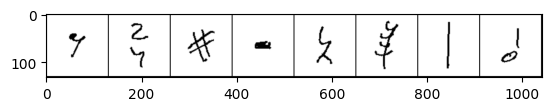

In [77]:
dataiter = iter(data['train'])
images, labels = next(dataiter)
images = images[:8]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
# print("Labels:" + ', '.join('%9s' % data['to_name'][labels[j].item()] for j in range(8)))

In [78]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
    net.to(device)
    net.train()
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0

        # Update learning rate when scheduled
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

        for i, batch in enumerate(dataloader, 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction

            losses.append(loss.item())
            sum_loss += loss.item()

            if i % print_every == print_every-1:    # print every 10 mini-batches
                if verbose:
                  print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
                sum_loss = 0.0
        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
            torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
    return losses

In [79]:
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resnet.fc = nn.Linear(512, 555) # This will reinitialize the layer as well

losses = train(resnet, data['train'], epochs=5, lr=.01, print_every=10, checkpoint_path=checkpoints)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[0,    10] loss: 4.264
[0,    20] loss: 1.047
[0,    30] loss: 0.478
[1,    10] loss: 0.175
[1,    20] loss: 0.163
[1,    30] loss: 0.167
[2,    10] loss: 0.095
[2,    20] loss: 0.090
[2,    30] loss: 0.075
[3,    10] loss: 0.038
[3,    20] loss: 0.040
[3,    30] loss: 0.036
[4,    10] loss: 0.020
[4,    20] loss: 0.027
[4,    30] loss: 0.021


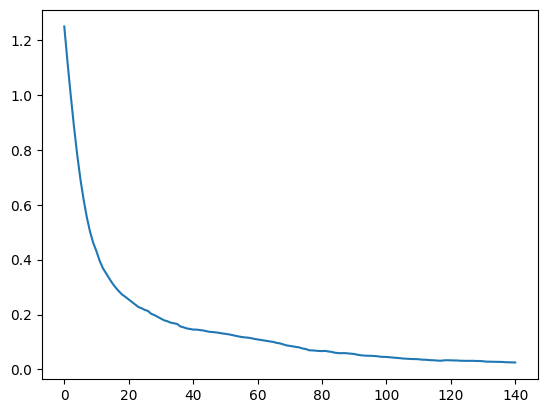

In [80]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')
plt.plot(smooth(losses,50))

In [81]:
from torch._C import ThroughputBenchmark
def predict(net, dataloader, ofname):
    out = open(ofname, 'w')
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    out.write("actual label, predicted label\n")
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%100 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            fname, _ = dataloader.dataset.samples[i]
            count = sum(x == y for x, y in zip(labels, predicted))
            correct += count
            total += len(images)
            for act, pred in zip(labels, predicted):
              out.write("{},{}\n".format(act, pred))
    out.close()
    accuracy = correct / total
    print("Total Accuracy: "+ str(accuracy))

Predict from training data

In [82]:
# Load model from checkpoint
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resnet.fc = nn.Linear(512, 555) # This will reinitialize the layer as well
state = torch.load(checkpoints + 'checkpoint-5.pkl')
resnet.load_state_dict(state['net'])

predict(resnet, data['train'], checkpoints + "train_preds.csv")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


0
Total Accuracy: tensor(0.9967)


Predict from validation data

In [83]:
# Load model from checkpoint
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resnet.fc = nn.Linear(512, 555) # This will reinitialize the layer as well
state = torch.load(checkpoints + 'checkpoint-5.pkl')
resnet.load_state_dict(state['net'])

predict(resnet, data['validation'], checkpoints + "val_preds.csv")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


0
100
200
300
400
500
600
700
800
900
1000
Total Accuracy: tensor(0.9282)


Predict on test data

In [84]:
# Load model from checkpoint
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resnet.fc = nn.Linear(512, 555) # This will reinitialize the layer as well
state = torch.load(checkpoints + 'checkpoint-5.pkl')
resnet.load_state_dict(state['net'])

predict(resnet, data['test'], checkpoints + "test_preds.csv")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


0
100
200
300
400
500
600
700
800
900
1000
Total Accuracy: tensor(0.9428)
